# Automation - Green Transition Relationship
Felix Zaussinger | 02.09.2021

## Core Analysis Goal(s)
1. check if automation scores correlate with greenness, or are higher for green/brown/neutral jobs
2.
3.

## Key Insight(s)
1.
2.
3.

In [1]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

Define directory structure

In [2]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

#### Merge automation risk and COVID-19 exposure data to own metadata

In [3]:
df_metadata = pd.read_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA_gbn.csv"),
    index_col=0
)

df_metadata.columns

Index(['id', 'concept_uri', 'preferred_label', 'isco_level_4', 'onet_code',
       'onet_occupation', 'isco_level_1', 'isco_level_2', 'isco_level_3',
       'occupation_type', 'n_new_green_tasks', 'n_existing_green_tasks',
       'n_non_green_tasks', 'greenness_vona_2018', 'greenness_vona_2018_v2',
       'total_paid_hours', 'annual_earnings', 'employment_share',
       'employment_count', 'job_zone', 'education_level',
       'related_work_experience', 'on_the_job_training', 'skill_level_ilo',
       'new_jobs_absorbing_ilo_2030_es', 'new_jobs_net_ilo_2030_es',
       'jobs_lost_net_ilo_2030_es', 'jobs_lost_reallocated_ilo_2030_es',
       'net_change_ilo_2030_es', 'new_jobs_absorbing_ilo_2030_ce',
       'new_jobs_net_ilo_2030_ce', 'jobs_lost_net_ilo_2030_ce',
       'jobs_lost_reallocated_ilo_2030_ce', 'net_change_ilo_2030_ce',
       'is_brown', 'is_green', 'is_neutral'],
      dtype='object')

In [4]:
occ_profiles = pd.read_csv(
    os.path.join(data_raw, "mcc_data", "processed", "ESCO_occupation_profiles.csv")
)

cols = ["concept_uri", "risk", "prevalence", "risk_category", "remote_labor_index", "physical_proximity", "exposure_score"]

In [5]:
df_merged = pd.merge(
    df_metadata,
    occ_profiles[cols],
    on="concept_uri",
    how="left"
)

df_merged["occ_type"] = df_merged[["is_brown", "is_neutral", "is_green"]].idxmax(axis=1)

In [6]:
merged_cols = cols + ["occ_type", 'is_brown', 'is_green', 'is_neutral', 'greenness_vona_2018_v2',
       'total_paid_hours', 'annual_earnings', 'employment_share',
       'employment_count', 'job_zone', 'education_level',
       'related_work_experience', 'on_the_job_training']

df_merged_sel = df_merged[merged_cols]

df_merged_sel.corr()

,risk,prevalence,remote_labor_index,physical_proximity,exposure_score,is_brown,is_green,is_neutral,greenness_vona_2018_v2,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training
risk,1.000000,-0.447603,0.234795,-0.117780,-0.235240,-0.138257,0.073125,0.049678,0.005821,-0.102589,0.043174,0.072657,0.072657,0.007814,0.013822,0.075063,-0.113298
prevalence,-0.447603,1.000000,-0.658416,0.109766,0.548869,0.282397,-0.118730,-0.125205,-0.068537,0.382922,-0.330013,-0.208011,-0.208011,-0.399029,-0.414113,-0.275538,0.177958
remote_labor_index,0.234795,-0.658416,1.000000,-0.294539,-0.853267,-0.366927,0.142684,0.180229,0.089281,-0.323381,0.493500,0.153483,0.153483,0.651638,0.661463,0.564568,0.029440
physical_proximity,-0.117780,0.109766,-0.294539,1.000000,0.721857,-0.020854,-0.101734,0.094734,-0.119196,-0.176303,-0.278389,0.129932,0.129931,-0.268971,-0.252423,-0.292694,-0.082296
exposure_score,-0.235240,0.548869,-0.853267,0.721857,1.000000,0.244944,-0.150862,-0.078380,-0.121855,0.143431,-0.479527,-0.042029,-0.042029,-0.600331,-0.605619,-0.542041,-0.040623
is_brown,-0.138257,0.282397,-0.366927,-0.020854,0.244944,1.000000,-0.157509,-0.644771,-0.105951,0.309086,-0.189963,-0.222982,-0.222982,-0.327262,-0.301076,-0.253189,-0.026855
is_green,0.073125,-0.118730,0.142684,-0.101734,-0.150862,-0.157509,1.000000,-0.653276,0.727873,0.156962,0.200614,0.007801,0.007802,0.152735,0.142020,0.204946,0.155735
is_neutral,0.049678,-0.125205,0.180229,0.094734,-0.078380,-0.644771,-0.653276,1.000000,-0.482169,-0.358467,-0.009640,0.182839,0.182837,0.133353,0.121525,0.035935,-0.100018
greenness_vona_2018_v2,0.005821,-0.068537,0.089281,-0.119196,-0.121855,-0.105951,0.727873,-0.482169,1.000000,0.138668,0.147234,-0.021775,-0.021774,0.145518,0.142352,0.140335,0.135397
total_paid_hours,-0.102589,0.382922,-0.323381,-0.176303,0.143431,0.309086,0.156962,-0.358467,0.138668,1.000000,0.251020,-0.355864,-0.355863,-0.184949,-0.244074,0.055965,0.388621


#### Are B/G/N occupations correlated with automation risk?
- brown occs are negatively correlated
- green and neutral occs are very weakly positively correlated

In [7]:
from scipy import stats

test = df_merged_sel[["is_brown", "is_green", "is_neutral", "risk"]].dropna()
print(stats.pointbiserialr(test.is_brown, test.risk))
print(stats.pointbiserialr(test.is_green, test.risk))
print(stats.pointbiserialr(test.is_neutral, test.risk))


PointbiserialrResult(correlation=-0.13825668385121317, pvalue=1.1390818027553507e-13)
PointbiserialrResult(correlation=0.07312499040080478, pvalue=9.122819519603425e-05)
PointbiserialrResult(correlation=0.04967764138866231, pvalue=0.007901309934273565)


#### What is the differential exposure of B/G/N to automation risk and COVID-19 measures?

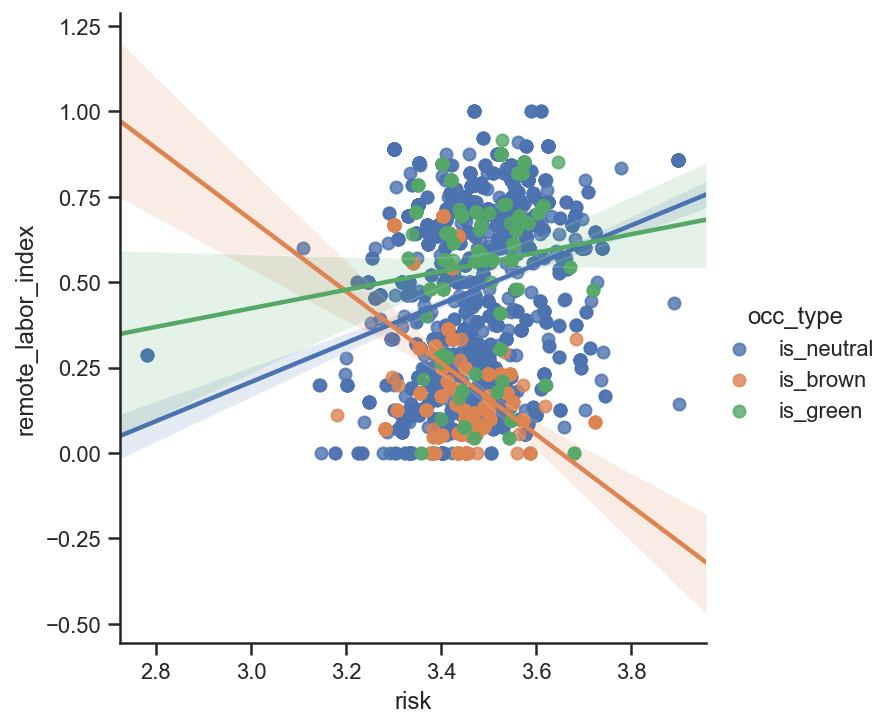

In [12]:
sns.lmplot(
    x="risk",
    y="remote_labor_index",
    hue="occ_type",
    truncate=False,
    data=df_merged_sel
)

plt.savefig(
    os.path.join(figure_dir, "automation", "rli_vs_risk.png"),
    bbox_inches="tight",
    dpi=300
)

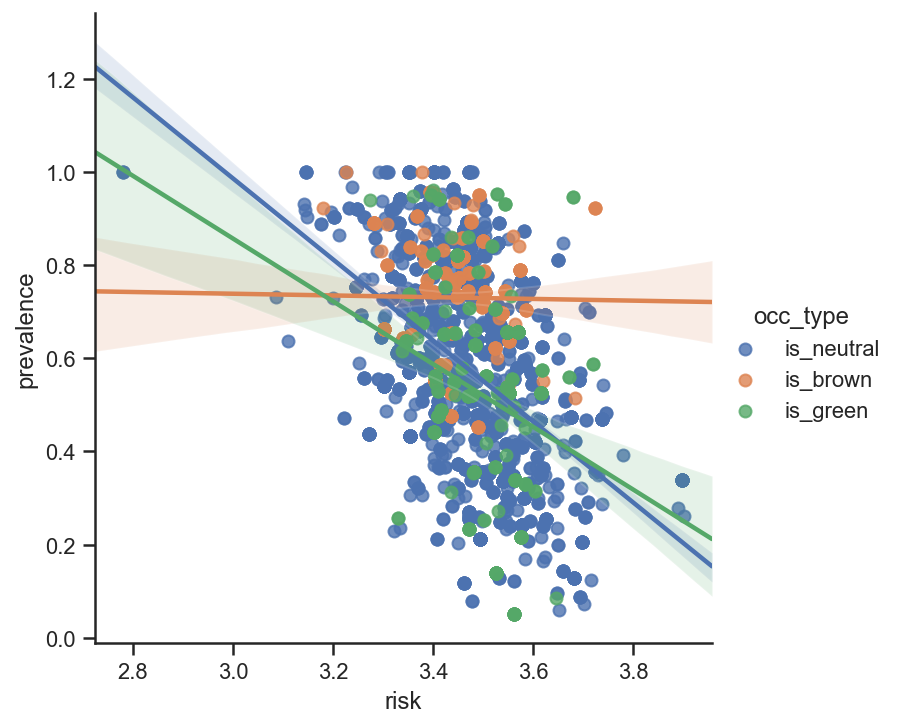

In [13]:
sns.lmplot(
    x="risk",
    y="prevalence",
    hue="occ_type",
    truncate=False,
    data=df_merged_sel
)

plt.savefig(
    os.path.join(figure_dir, "automation", "prevalence_vs_risk.png"),
    bbox_inches="tight",
    dpi=300
)

#### Does the greenness of an occupation correlate with automation risk and COVID-19 exposure measures?

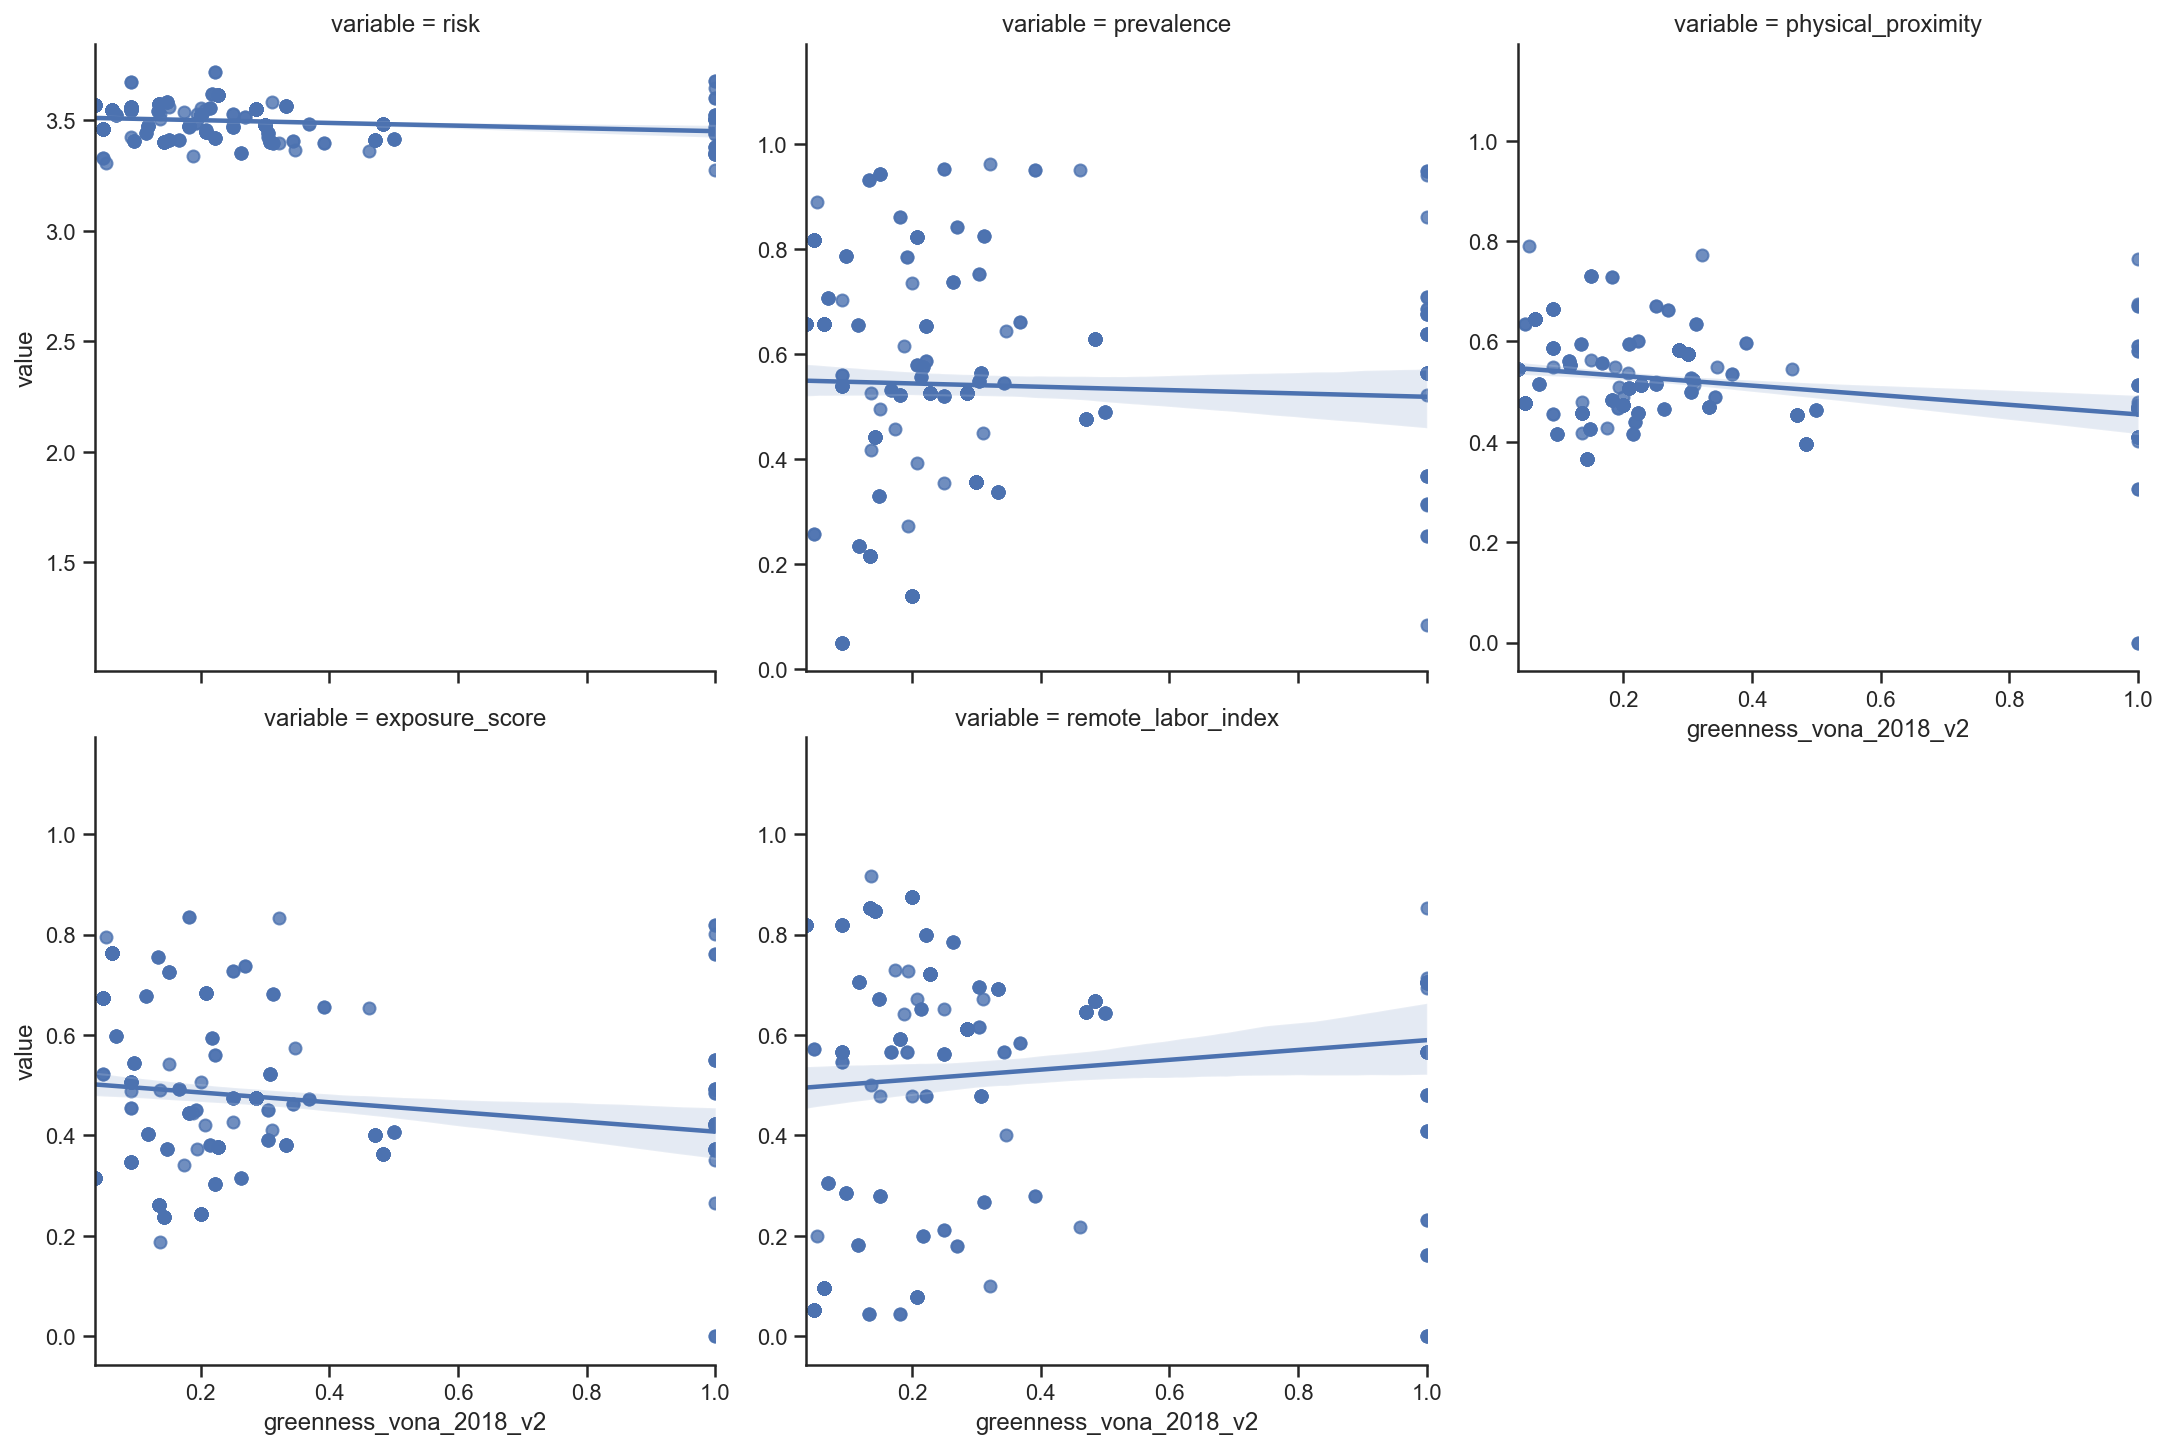

In [10]:
greenness_subset = df_merged_sel[
    ["risk", "prevalence", "physical_proximity", "exposure_score", "remote_labor_index", "greenness_vona_2018_v2"]
].query("greenness_vona_2018_v2 > 0")

greenness_subset_long = greenness_subset.melt(
    id_vars="greenness_vona_2018_v2",
    value_vars=["risk", "prevalence", "physical_proximity", "exposure_score", "remote_labor_index"]
)

greenness_subset_long = greenness_subset_long.dropna()

sns.lmplot(
    x="greenness_vona_2018_v2",
    y="value",
    col="variable",
    data=greenness_subset_long,
    sharey=False,
    #sharex=True,
    col_wrap=3,
)

plt.savefig(
    os.path.join(figure_dir, "automation", "greenness_subset_correlations.png"),
    bbox_inches="tight",
    dpi=300
)

#### How do automation risk and COVID-19 exposure measures vary between G/B/N occupations?

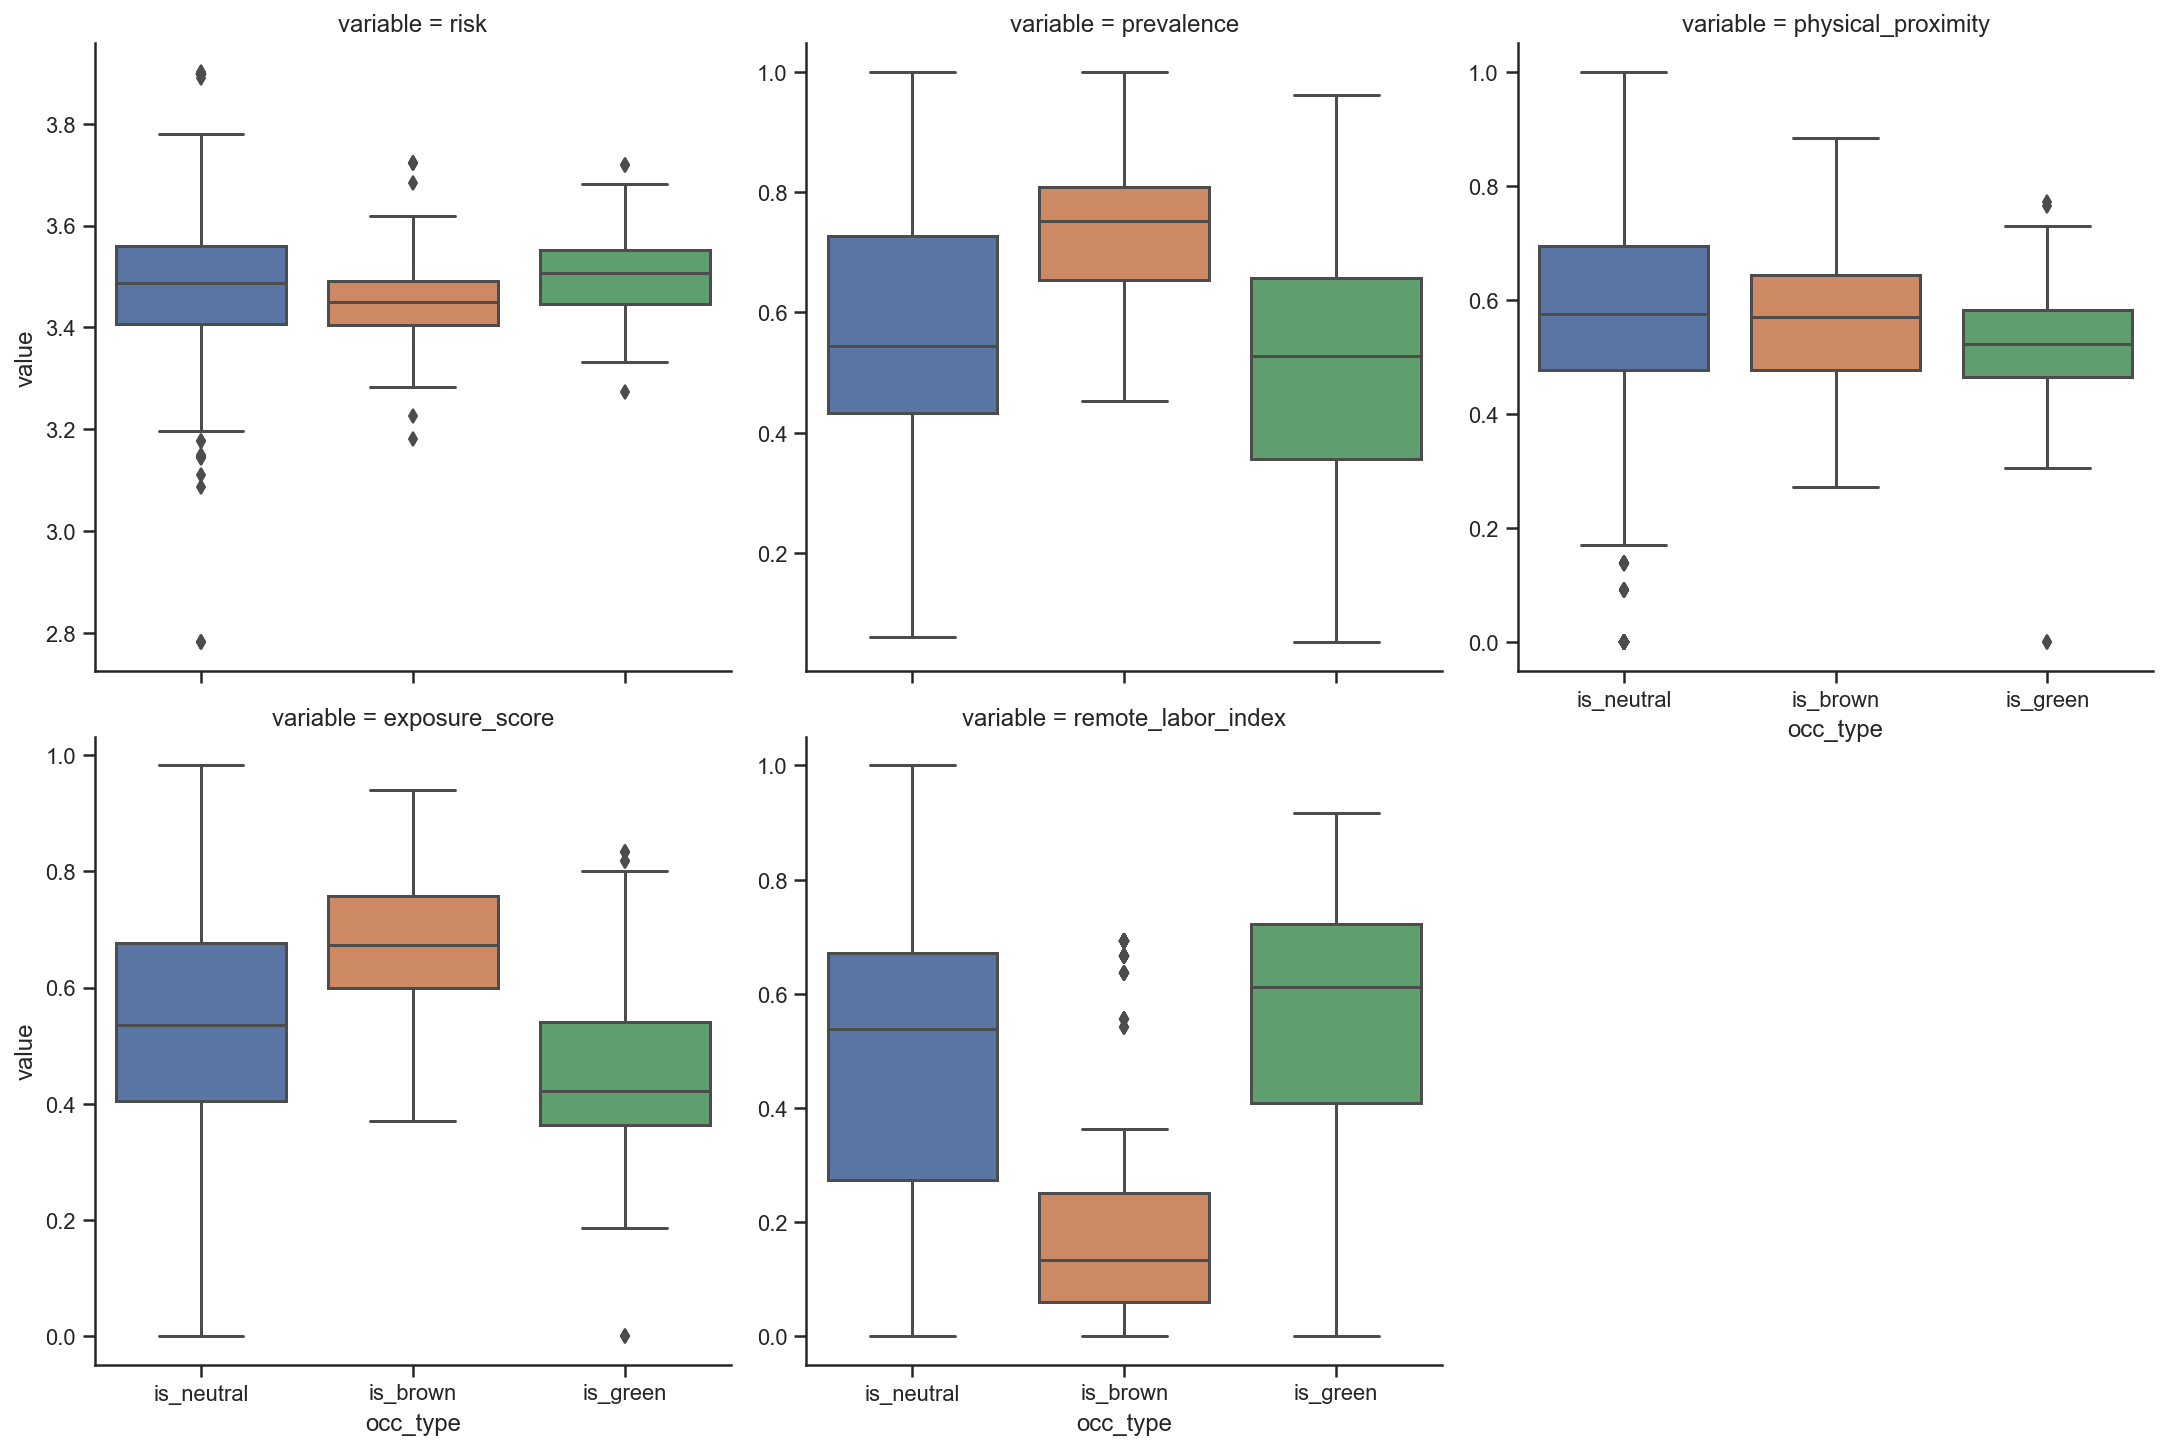

In [11]:
sns.catplot(
    x="occ_type",
    y="value",
    col="variable",
    col_wrap=3,
    kind="box",
    sharey=False,
    data=df_merged_sel.melt(
    id_vars=["occ_type"],
    value_vars=["risk", "prevalence", "physical_proximity", "exposure_score", "remote_labor_index"]
    )
)

plt.savefig(
    os.path.join(figure_dir, "automation", "gbn_characteristics.png"),
    bbox_inches="tight",
    dpi=300
)
